# News Article Recommendation System

The goal of this project is to build an article recommendation system based on the given users' previously read articles

Additionally, an exploratory data analysis will be conducted to uncover key insights into the users reading patterns as well as to determine which types of articles receive the most user interactions and, hence, bring more profit to the company

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings("ignore")

## Importing the datasets

In [2]:
if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "/Users/admin/Downloads/Articles_data/clicks/clicks"
    
    clicks_path = clicks_path + sorted(
            [os.path.join(clicks_dir, file) for file in os.listdir(clicks_dir) if file.endswith(".csv")])
    
    clicks = []
    
    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        clicks.append(df)
        
    clicks_df = pd.concat(clicks, axis=0, ignore_index=True)
    clicks_df.to_csv('clicks.csv', index=False)
else:
    clicks_df = pd.read_csv('clicks.csv')

In [3]:
articles_df = pd.read_csv('/Users/admin/Downloads/Articles_data/articles_metadata.csv')

## Column descriptions

### Clicks_df:

**User_id** - Unique user ID

**Session_id** - Unique Session ID

**Session_start** - Timestamp of the first interaction of the session

**Session_size** - Number of interactions in the session (the dataset only includes sessions with 2 or more interactions)

**Click_article_id** - Article id user interacted with

**Click_timestamp** - Timestamp of the interaction

**Click_environment** - ID of the Environment: 1 - Facebook Instant Article, 2 - Mobile App, 3 - AMP (Accelerated Mobile Pages), 4 - Web

**Click_deviceGroup** - ID of the Device Type: 1 - Tablet, 2 - TV, 3 - Empty, 4 - Mobile, 5 - Desktop

**Click_os** - ID of the Operational System: 1 - Other, 2 - iOS, 3 - Android, 4 - Windows Phone, 5 - Windows Mobile, 6 - Windows, 7 - Mac OS X, 8 - Mac OS, 9 - Samsung, 10 - FireHbbTV, 11 - ATV OS X, 12 - tvOS, 13 - Chrome OS, 14 - Debian, 15 - Symbian OS, 16 - BlackBerry OS, 17 - Firefox OS, 18 - Android, 19 - Brew MP, 20 - Chromecast, 21 - webOS, 22 - Gentoo, 23 - Solaris

**Click_country** - ID of the country user interacted from *(ID explanation not provided by the data owners)*

**Click_region** - ID of the region user interacted from *(ID explanation not provided by the data owners)*

**click_referrer_type** - ID of the type of referrer that sent the user to the article *(ID explanation not provided by the data owners)*


### Articles_df:

**Articled_id** - Unique article ID

**Category_id** - The category ID of the article *(ID explanation not provided by the data owners)*

**Created_at_ts** - Timestamp of the article begin published

**Publisher_id** - Id of the publisher of the article *(ID explanation not provided by the data owners)*

**Words_count** - Number of words in the article


## Checking the datasets

In [4]:
print(articles_df.info())

articles_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB
None


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [5]:
print(clicks_df.info(show_counts=True))

clicks_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype
---  ------               --------------    -----
 0   user_id              2988181 non-null  int64
 1   session_id           2988181 non-null  int64
 2   session_start        2988181 non-null  int64
 3   session_size         2988181 non-null  int64
 4   click_article_id     2988181 non-null  int64
 5   click_timestamp      2988181 non-null  int64
 6   click_environment    2988181 non-null  int64
 7   click_deviceGroup    2988181 non-null  int64
 8   click_os             2988181 non-null  int64
 9   click_country        2988181 non-null  int64
 10  click_region         2988181 non-null  int64
 11  click_referrer_type  2988181 non-null  int64
dtypes: int64(12)
memory usage: 273.6 MB
None


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


No null values in either dataset, so no need to clean for those. At first glance, there seem to be some useless columns, specifically **Unnamed: 0** and **publisher_id** since the former is simply a repeat column of the index and the latter only contains 0s

Additionally, some columns contain datetime information, so their data types will have to be changed to more accurately reflect their contents

Lastly, there seems to be at least one row in the articles dataset that has a **word count of 0**, so that and any other such rows (if there are any) will have to be removed

## Changing data types and transforming values

In addition to transforming the columns containing time information to datetime, for the purpose of the analysis I also decided to change the values in the known "category" columns such as **click_os**, **click_deviceGroup**, etc. from their IDs to the values they represent to increase readability

Additionally, their data types will be changed to **category** to reduce space and decrease computing time 

In [6]:
articles_df = articles_df.drop(columns=['publisher_id'])
articles_df

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
...,...,...,...,...
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126


Since the **publisher_id** column contained only 0s, there is not much use for it in the context of the analysis, as such, I decided to drop it

In [7]:
clicks_df['session_start'] = pd.to_datetime(clicks_df['session_start'],unit='ms')
clicks_df['click_timestamp'] = pd.to_datetime(clicks_df['click_timestamp'],unit='ms')

articles_df['created_at_ts'] = pd.to_datetime(articles_df['created_at_ts'],unit='ms')

In [8]:
environment = {1 : 'Facebook Instant Article',
               2 : 'Mobile App',
               3 : 'AMP',
               4 : 'Web'}

clicks_df = clicks_df.replace({'click_environment': environment})
clicks_df['click_environment'] = clicks_df['click_environment'].astype('category')

clicks_df['click_environment'].value_counts()

Web                         2904478
Mobile App                    79743
Facebook Instant Article       3960
Name: click_environment, dtype: int64

In [9]:
device = {1 : 'Tablet',
          2 : 'TV',
          3 : 'Empty',
          4 : 'Mobile',
          5 : 'Desktop'}

clicks_df = clicks_df.replace({'click_deviceGroup': device})
clicks_df['click_deviceGroup'] = clicks_df['click_deviceGroup'].astype('category')

clicks_df['click_deviceGroup'].value_counts()

Tablet     1823162
Empty      1047086
Mobile      117640
Desktop        283
TV              10
Name: click_deviceGroup, dtype: int64

In [10]:
osys = {1 : 'Other', 2 : 'iOS', 3 : 'Android', 4 : 'Windows Phone', 5 : 'Windows Mobile', 6 : 'Windows', 
        7 : 'Mac OS X', 8 : 'Mac OS', 9 : 'Samsung', 10 : 'FireHbbTV', 11 : 'ATV OS X', 12 : 'tvOS', 
        13 : 'Chrome OS', 14 : 'Debian', 15 : 'Symbian OS', 16 : 'BlackBerry OS', 17 : 'Firefox OS', 
        18 : 'Android', 19 : 'Brew MP', 20 : 'Chromecast', 21 : 'webOS', 22 : 'Gentoo', 23 : 'Solaris'}

clicks_df = clicks_df.replace({'click_os': osys})
clicks_df['click_os'] = clicks_df['click_os'].astype('category')

clicks_df['click_os'].value_counts()

Firefox OS        1738138
iOS                788699
Chromecast         369586
tvOS                60096
Chrome OS           23711
Brew MP              6384
Windows Mobile       1513
Android                54
Name: click_os, dtype: int64

In [11]:
#Dropping articles with 0 words

articles_df = articles_df.drop(articles_df[articles_df['words_count'] == 0].index)

## Merging the Datasets

This will be done solely for the pupose of analysis and will not be used when creating the neural network, which will instead use both of the original datasets 

In [12]:
merger = clicks_df.rename(columns={'click_article_id' : 'article_id'})

df = pd.merge(merger,articles_df, on='article_id')

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2988116 entries, 0 to 2988115
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   user_id              2988116 non-null  int64         
 1   session_id           2988116 non-null  int64         
 2   session_start        2988116 non-null  datetime64[ns]
 3   session_size         2988116 non-null  int64         
 4   article_id           2988116 non-null  int64         
 5   click_timestamp      2988116 non-null  datetime64[ns]
 6   click_environment    2988116 non-null  category      
 7   click_deviceGroup    2988116 non-null  category      
 8   click_os             2988116 non-null  category      
 9   click_country        2988116 non-null  int64         
 10  click_region         2988116 non-null  int64         
 11  click_referrer_type  2988116 non-null  int64         
 12  category_id          2988116 non-null  int64         
 1

## Exploratory Data Analysis (EDA)

The data was relatively clean to begin with, so there was minimal cleaning needed to be done, as such, we can move on to the EDA

The goal will be to find the following insights:

1 - Most popular article categories

2 - The most popular format or reading (Mobile app, Web, AMP) as well as the most common device type for potential optimisation in the future

3 - Peak readership times/days 

4 - The countries with the most readers

5 - Whether readers prefer shorter or longer articles

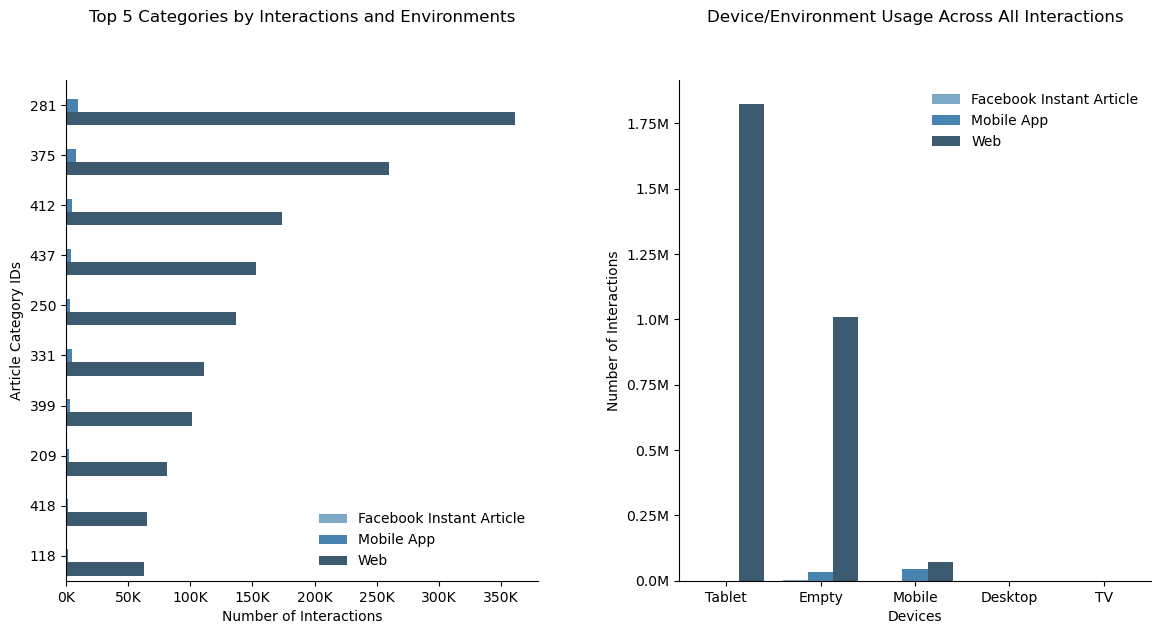

In [13]:
plt.figure(figsize=(14, 6.5))


plt.subplot(1,2,1)
ax1 = sns.countplot(y="category_id", hue='click_environment', data=df, palette="Blues_d",
              order=df['category_id'].value_counts().iloc[:10].index)

sns.despine(right = True, top = True)
plt.legend(frameon=False)

xlabels = [str(int(x)) + 'K' for x in ax1.get_xticks()/1000]
ax1.set_xticklabels(xlabels)
plt.xlabel('Number of Interactions')
plt.ylabel('Article Category IDs')
plt.title('Top 5 Categories by Interactions and Environments', y=1.1)


plt.subplot(1,2,2) 

ax2 = sns.countplot(x="click_deviceGroup", hue='click_environment', data=df, palette="Blues_d",
              order=df['click_deviceGroup'].value_counts().index)

plt.legend(frameon=False)
sns.move_legend(ax2, "upper right")
sns.despine(right = True, top = True)

ylabels = [str(x) + 'M' for x in ax2.get_yticks()/1_000_000]
ax2.set_yticklabels(ylabels)
plt.xlabel('Devices')
plt.ylabel('Number of Interactions')
plt.title('Device/Environment Usage Across All Interactions', y=1.1)

plt.subplots_adjust(wspace=0.3)

plt.show()

Though the category names were not provided, we can still see what the top performing categories are, as well as that the overwhelming majority of the readers prefer to read articles through the Web

Additionally and surprisingly, most users tend to read on tablets and almost none of them read on desktop. The cause for this data may lie in the **Empty** category, wherein the items may in fact be representing the Desktop users.

Lastly, views from Facebook Instant Articles are practically non-existant and Mobile App views pale in comparison to those on the Web. If that is indeed the case, Globo might want to consider developing a Tablet app (provided they don't have one already), seeing as most of its readers read articles on the tablet, which would still remain to be the case even if the Empty category turned out to contain data from Desktop users

In [14]:
time_df = df.copy()

time = df.groupby(pd.Grouper(key="session_start", freq="H"))['session_start'].count().sort_values(ascending=False)

time_df["dates"] = time_df["session_start"].dt.floor("D")
dates = sorted(time_df.dates.unique())

time_df["hours"] = time_df["session_start"].dt.hour
hours = sorted(time_df.hours.unique())

time_df['day_of_week'] = time_df['session_start'].dt.day_name()

In [15]:
time_df[['dates','day_of_week']]

,dates,day_of_week
0,2017-10-01,Sunday
1,2017-10-01,Sunday
2,2017-10-01,Sunday
3,2017-10-01,Sunday
4,2017-10-01,Sunday
...,...,...
2988111,2017-10-17,Tuesday
2988112,2017-10-17,Tuesday
2988113,2017-10-17,Tuesday
2988114,2017-10-17,Tuesday


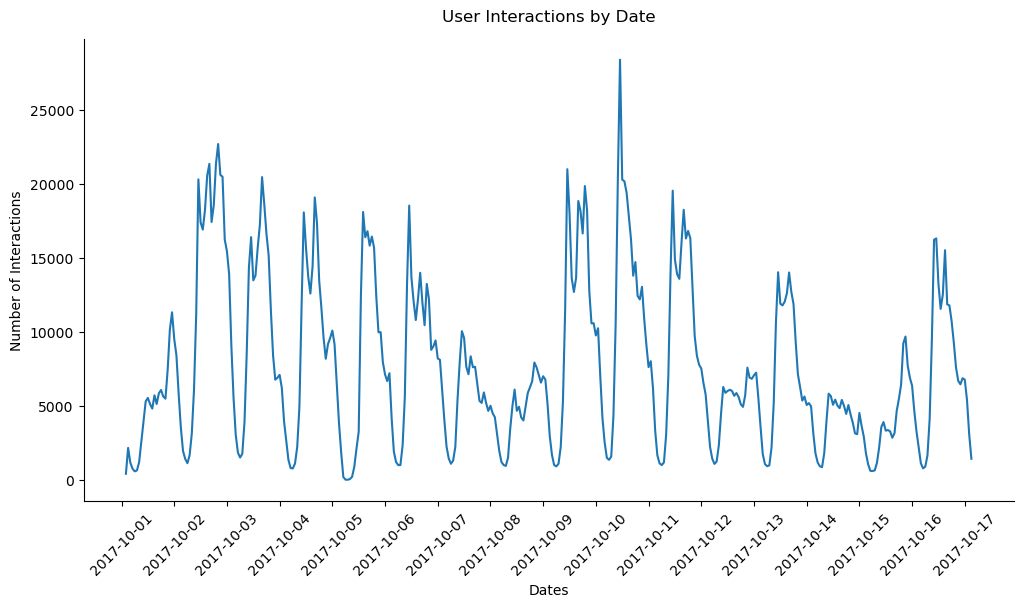

In [16]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(data=time)

ax.set_xticks(dates)
plt.xticks(rotation=45)
sns.despine(right = True, top = True)
plt.xlabel('Dates')
plt.ylabel('Number of Interactions')
plt.title('User Interactions by Date', y=1.02)

plt.show()

From the graph above, we can see some interesting peak activity on 2017-10-10 (Tuesday) and 2017-10-02 (Monday), as well as the lowest points being on 2017-10-07 (Saturday), 2017-10-09(Sunday), 2017-10-12 (Thursday) and 2017-10-14 (Saturday)

Though the sample size is small in therms of the timeframe (only 17 full days), we can see that users are mostly active Monday - Wednesday, after which user activity slowly starts to fall of and significantly decreases on the weekends

To confirm this theory, I will check the user activity distribution by the days of the week within the time frame of 2017-10-01 to 2017-10-14 to ensure that there is an even number of days taken into account so as to not skew the data

Additionally, I will also check the user activity distribution throughout each hour of the day to determine the peak hours

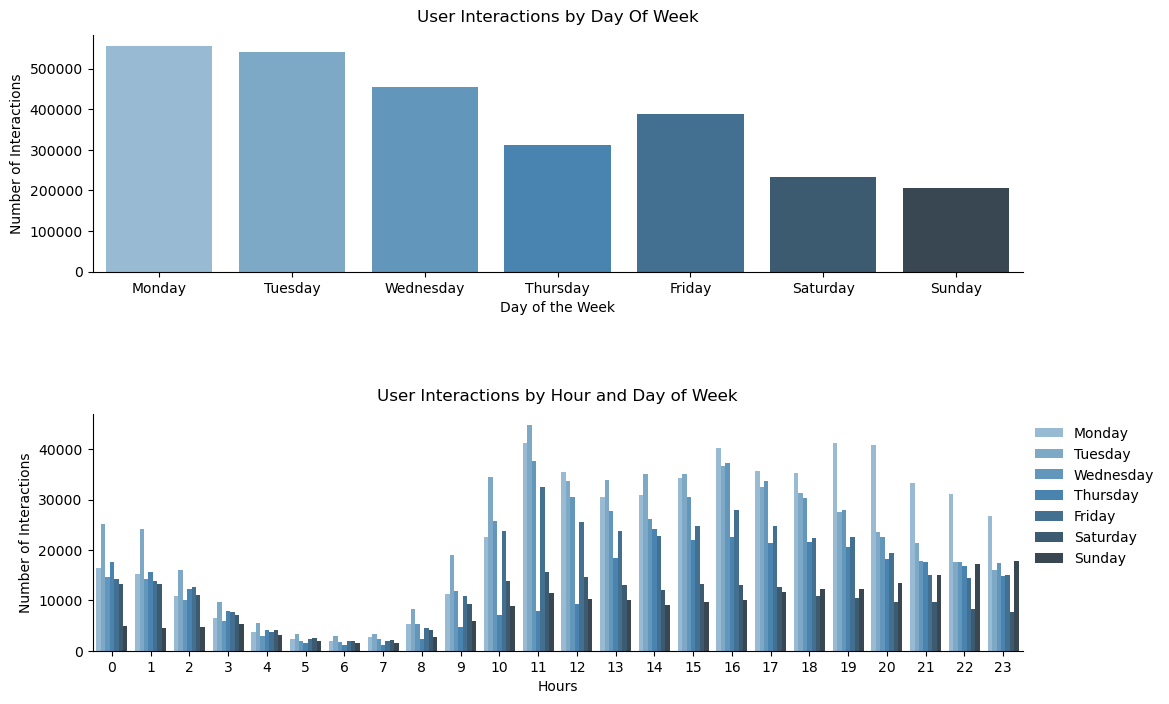

In [17]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)

weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax1 = sns.countplot(time_df.loc[time_df['dates'] < datetime.datetime(2017,10,15), 'day_of_week']
              ,palette="Blues_d", order=weekdays)

sns.despine(right = True, top = True)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Interactions')
plt.title('User Interactions by Day Of Week', y=1.02)

plt.subplot(2,1,2)


ax2 = sns.countplot(time_df.loc[time_df['dates'] < datetime.datetime(2017,10,15), 'hours']
                    ,hue=time_df['day_of_week'], hue_order=weekdays,palette="Blues_d")

sns.despine(right = True, top = True)
plt.xlabel('Hours')
plt.ylabel('Number of Interactions')
plt.title('User Interactions by Hour and Day of Week', y=1.02)

plt.legend(frameon=False)
sns.move_legend(ax2, "upper left",bbox_to_anchor=(1, 1))
sns.despine(right = True, top = True)

plt.subplots_adjust(hspace=0.6)

plt.show()

The theory holds true (at least for this sample timeframe), with Monday and Tuesday being the peak activity days. Wednesday falls slightly behind them and after that we see a decline in user activity. Interestingly, Thursday seems to be almost comparable to the weekend days in terms of activity and generally stands out from other weekdays

In terms of activity by hours, 11:00 and 16:00 are undoubtedly the peak hours, with a steady activity distribution throughout the day up until 20:00 - 21:00, after which we see a decline.

4:00 - 8:00 is the least active timeframe with almost no user activity compared to the average

Text(0.5, 1.02, 'Top 2-10 countries By Unique Users \n (Without Brazil)')

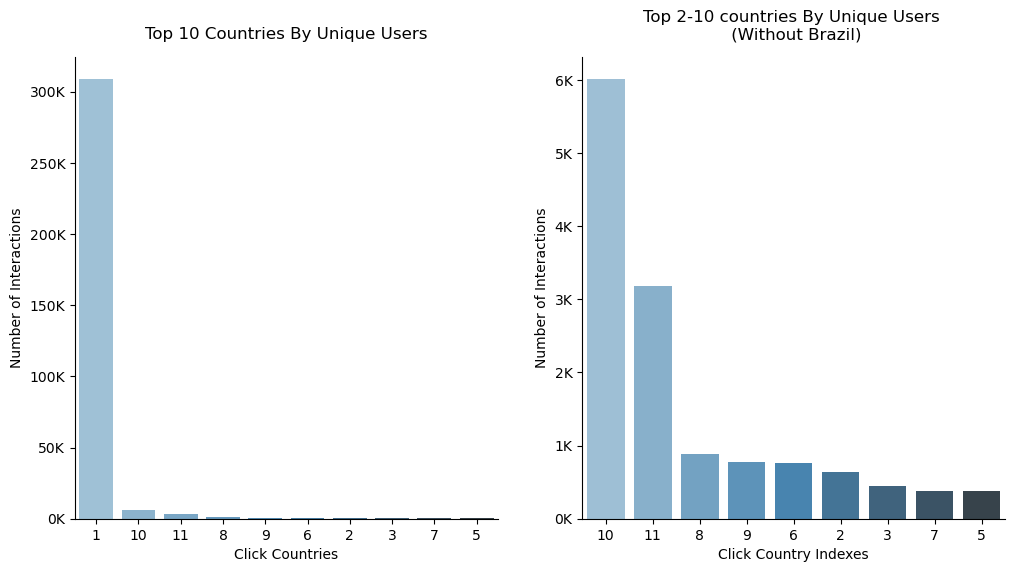

In [18]:
plt.figure(figsize=(12,6))

plt.subplot(121)

ax = sns.countplot(df.drop_duplicates(subset=['user_id'])['click_country'], palette="Blues_d",
              order=df.drop_duplicates(subset=['user_id'])['click_country'].value_counts().iloc[:10].index)

ylabels = [str(int(x)) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
sns.despine(right = True, top = True)
plt.xlabel('Click Countries')
plt.ylabel('Number of Interactions')
plt.title('Top 10 Countries By Unique Users', y=1.02)

plt.subplot(122)

ax = sns.countplot(df.drop_duplicates(subset=['user_id'])['click_country'], palette="Blues_d",
              order=df.drop_duplicates(subset=['user_id'])['click_country'].value_counts().iloc[1:10].index)

ylabels = [str(int(x)) + 'K' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels)
sns.despine(right = True, top = True)
plt.xlabel('Click Country Indexes')
plt.ylabel('Number of Interactions')
plt.title(f'Top 2-10 countries By Unique Users \n (Without Brazil)', y=1.02)

Since Globo.com is a Brazilian media company that produces most of its content in Portugese, it would be reasonable to assume that the country indexed 1 is Brazil for the purpose of this analysis. If the index explanations had been provided this could be confirmed, but alas...

With this in mind, we can see that Brazil represents almost the entirety of the user locations. Despite country number 10 being in second place in terms of user population, its total number of interactions is almost 50 times lower than that of Brazil. As for country number 11 at third place, its number of user interactions is an even more astounding ~100 times lower than that of Brazil.

Overall, Globo's user base is very homogenous in terms of location diversity, however, if there are any plans for future expansion into foreign markets, countries 10 and 11 show the most promise (provided that the given sample data is representative of the overall trends)

Additionally, what should be noted is that VPN usage by the users can neither be accounted for nor verified, so if there are such cases in the provided data, the data might potentially show more interactions outside of Brazil than there were in reality. However, since, again, this can neither be accounted for nor verified, we will continue under the assumption that the data is reflective of reality

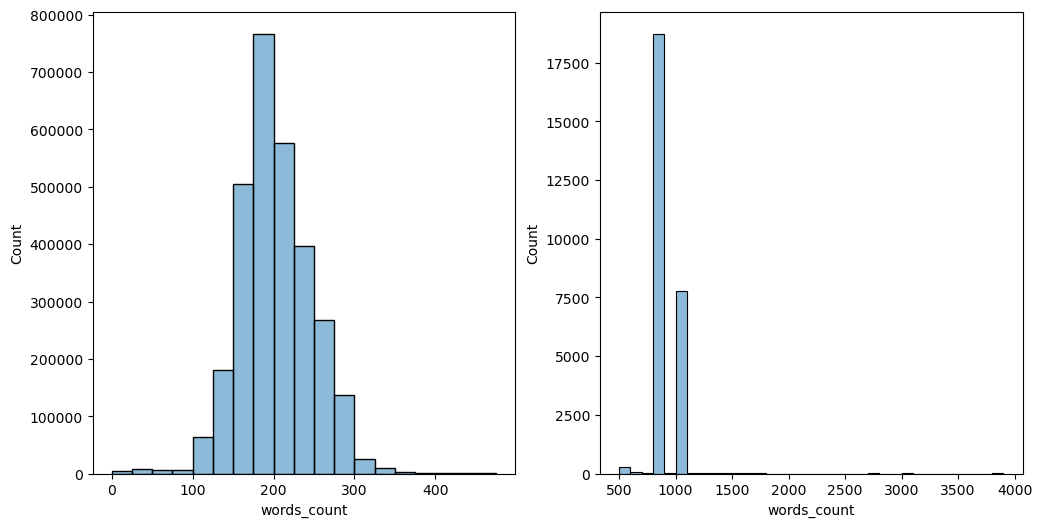

In [19]:
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)

sns.histplot(data= df.loc[df['words_count'] < 500, 'words_count'], 
             bins=np.arange(0,500,25), palette="Blues_d", alpha=0.5)

plt.subplot(1,2,2)

sns.histplot(data= df.loc[df['words_count'] > 500, 'words_count'],
             bins=np.arange(500,4000,100), palette="Blues_d", alpha=0.5)

plt.show()

As we can see, the most read articles are within the 150-250 word count range, however, this may very well be due to there being much more articles within said range than outside of it.

To determine whether this hypothesis is true, I'll compare the number of interactions to the number of articles within the same word count range and determine the average number of interactions per article using the following formula:

**(Number of Interactions / Number of Articles Within Word Count Range)**

In [20]:
words_df = pd.DataFrame(df['words_count'].round(-1).value_counts() / 
                        articles_df['words_count'].round(-1).value_counts()).reset_index()

words_df.rename(columns={'index': 'word_count',
                         'words_count' : 'interactions_per_art'}, inplace=True)

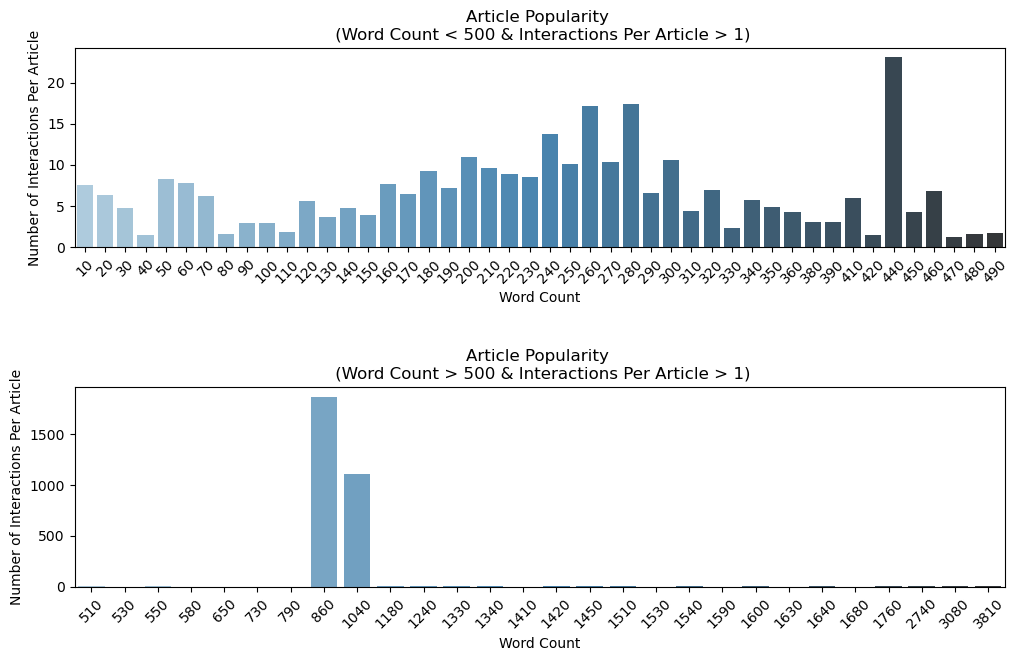

In [21]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)

sns.barplot(data=words_df.loc[(words_df.word_count <= 500) & (words_df.interactions_per_art > 1)], 
            x="word_count", y="interactions_per_art", palette="Blues_d")

plt.xticks(rotation=45)
plt.xlabel('Word Count')
plt.ylabel('Number of Interactions Per Article')
plt.title('Article Popularity \n (Word Count < 500 & Interactions Per Article > 1)')

plt.subplot(2,1,2)

sns.barplot(data= words_df[(words_df.word_count > 500) & (words_df.interactions_per_art > 1)], 
            x="word_count", y="interactions_per_art", palette="Blues_d")

plt.xticks(rotation=45)
plt.xlabel('Word Count')
plt.ylabel('Number of Interactions Per Article')
plt.title('Article Popularity \n (Word Count > 500 & Interactions Per Article > 1)')

plt.subplots_adjust(hspace=0.7)

plt.show()

Surprisingly, article popularity changes significantly when taking into account the total number of articles

More specifically, **articles having close to 860 and 1040 word counts have over 1000 interactions per article**, while the previous leaders (150 - 250) have 15 interactions per article at most

Overall, though, considering that the total number of the 2 most popular high-word-count article word counts is less than 20, one might be inclined to consider them anomalies and not jump to any conclusions due to the small sample size

If that approach is to be taken, then the numbers on user preferences change slightly, making the 240-290 category the most appealing

## Building Content-Based Recommendation Model

The plan is to build a content-based recommendation model that recommends articles most similar to those in the given user's most read category(ies) based on the article embeddings

### Retrieving article embeddings

In [22]:
embeds = pd.read_pickle('/Users/admin/Downloads/Articles_data/articles_embeddings.pickle')
embeds.shape

(364047, 250)

In [23]:
embeds = embeds[:50000]
embeds.shape

(50000, 250)

In [24]:
cosine_sims  = cosine_similarity(embeds, embeds)
cosine_sims.shape

(50000, 50000)

Since the machine I'm working on has only 8GB of RAM, computing the cosine similarities for all 364047 articles caused crashes for me. As such, I have decided to take a smaller sample size, though it can be upscaled by increasing the sample sized if launched on a more powerful machine

### Resizing the articles and clicks dataframes due to hardware limitations

As mentioned above, I was forced to downsize the sample size of article embeddings due to hardware limitations, as such, the articles and clicks dataframe will also need to be scaled down to match the remaining embeddings

In [25]:
articles_df = articles_df.loc[:50000]
articles_df

,article_id,category_id,created_at_ts,words_count
0,0,0,2017-12-13 05:53:39,168
1,1,1,2014-07-14 12:45:36,189
2,2,1,2014-08-22 00:35:06,250
3,3,1,2014-08-19 17:11:53,230
4,4,1,2014-08-03 13:06:11,162
...,...,...,...,...
49996,49996,99,2015-07-15 05:00:01,245
49997,49997,99,2015-07-17 11:34:16,166
49998,49998,99,2015-07-16 15:38:41,185
49999,49999,99,2015-07-21 16:35:45,266


In [26]:
# Only leaving users that have interacted with 2 or more of the remaining articles after the downsizing
clicks_df = clicks_df.loc[clicks_df['click_article_id'].isin(articles_df['article_id'].unique())]
clicks_df = clicks_df[clicks_df['user_id'].map(clicks_df['user_id'].value_counts()) > 1]
clicks_df

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
5,2,1506825435299739,2017-10-01 02:37:15,2,30970,2017-10-01 03:05:20.575,Web,Tablet,Firefox OS,1,24,2
8,4,1506825528135741,2017-10-01 02:38:48,2,48915,2017-10-01 03:02:07.593,Web,Tablet,Firefox OS,1,17,1
9,4,1506825528135741,2017-10-01 02:38:48,2,44488,2017-10-01 03:02:37.593,Web,Tablet,Firefox OS,1,17,1
64,23,1506825787353760,2017-10-01 02:43:07,3,2137,2017-10-01 03:04:16.691,Web,Empty,iOS,1,21,1
72,26,1506825860299763,2017-10-01 02:44:20,3,4658,2017-10-01 03:06:52.936,Web,Empty,iOS,1,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2988154,215135,1508211325718322,2017-10-17 03:35:25,4,36162,2017-10-17 03:43:01.153,Web,Empty,iOS,1,13,2
2988157,215135,1508211325718322,2017-10-17 03:35:25,4,30760,2017-10-17 03:43:38.251,Web,Empty,iOS,1,13,2
2988159,130978,1508211326383323,2017-10-17 03:35:26,2,36162,2017-10-17 03:35:56.313,Web,Empty,Chromecast,1,13,5
2988160,31571,1508211348208324,2017-10-17 03:35:48,2,36162,2017-10-17 03:38:25.561,Web,Empty,iOS,1,25,2


In [27]:
# Merging articles_df and clicks_df for future use
merger = clicks_df.rename(columns={'click_article_id' : 'article_id'})

df = pd.merge(merger,articles_df, on='article_id')

In [28]:
user_info = df.groupby(['user_id','article_id', 'category_id']).size().to_frame().reset_index()
user_info = user_info[['user_id', 'article_id', 'category_id']]
user_info[user_info['user_id'] == 5]

user_ratings = pd.merge(user_info, df.groupby(['user_id', 'category_id']).size().to_frame().reset_index(),
                  on=['user_id','category_id'])
user_ratings.rename(columns = {0:'n_clicks'}, inplace = True)
user_ratings['rating'] = user_ratings['n_clicks'].div(user_ratings.groupby('user_id')['n_clicks'].transform('max'))

user_ratings

,user_id,article_id,category_id,n_clicks,rating
0,2,30760,26,2,1.0
1,2,30970,26,2,1.0
2,4,44488,81,1,1.0
3,4,48915,92,1,1.0
4,5,36399,43,2,1.0
...,...,...,...,...,...
130778,322818,16749,7,2,1.0
130779,322829,5583,6,2,1.0
130780,322829,5595,6,2,1.0
130781,322892,39894,66,1,1.0


Here I've created a dataframe containing each user's read articles with the number of articles viewed in each category and the categories' respective weights. This will be used in forming the recommendations for each user

In [29]:
def Recommend_article(userID):
    
    # Getting category preferences of selected user
    
    user_weights = user_ratings[user_ratings['user_id'] == userID]

    # Calculating article similarities based on the article embeddings
            
    similarity_score = []
    # Iterating over every article the user has read with a maximum category rating
    for row in user_weights.loc[user_weights['rating'] == user_weights['rating'].max(),'article_id']:
        
        # Getting the articles' cosine similarities and turning them into a list: (article_id, cosine_sim) for each
        sim_scores = list(enumerate(cosine_sims[row])) 
        
        # Sorting by the highest sim scores and retrieving the top 10 (not including the article itself)
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        
        # Appending the top 10 most similar articles to the empty list
        similarity_score += sim_scores
    
    # Sorting the final list of articles by similarity score
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True) #Sorting the results by sim score
            
    # Building a dataframe that will contain all the recommended articles, their info and similarity scores
    recommendation_df = pd.DataFrame(columns=['article_id', 'category_id', 'sim_score'])
    for row in similarity_score:
        
        # Note: since the article_id in articles_df is the same as the articles index, they are interchangeable
        article_id = row[0]
        category_id = articles_df.loc[article_id]['category_id']
        sim_score = row[1]
        
        # Creating a new row in the dataframe for each article
        new_row = {'article_id': article_id, 'category_id': category_id, 'sim_score': sim_score}
        recommendation_df = recommendation_df.append(new_row, ignore_index=True)
        
    #Calculate final score
    recommendation_df = recommendation_df.sort_values(by=['sim_score'], ascending=False)
    
    recommendation_list = np.array(recommendation_df.head(5).article_id.values, dtype='int')
    
    return recommendation_list, recommendation_df

In [30]:
Recommend_article(5)

(array([34833, 35956, 36280, 35703, 36328]),
    article_id  category_id  sim_score
 0     34833.0         43.0   0.781665
 1     35956.0         43.0   0.762639
 2     36280.0         43.0   0.760696
 3     35703.0         43.0   0.758213
 4     36328.0         43.0   0.748250
 5     33376.0         36.0   0.745505
 6     33846.0         43.0   0.738912
 7     36704.0         43.0   0.738314
 8     36135.0         43.0   0.737733
 9     36680.0         43.0   0.729263)

The model seems to work exactly as intended!

In terms of the process, it works as follows:

1 - Takes every user interaction from user_ratings

2 - For each article in the user's most read category(ies) retrieves said article's cosine similarity scores in regards to other articles and appends the top 10 to an empty list

3 - Sorts the empty list by the cosine similarity score

4 - Creates a new dataframe containing information about each recommended article as well as its cosine similarity score

5 - Outputs the top 5 articles as well as the dataframe 

# Plans for the future:

This was the initial idea for a recommendation model, however I also plan to create a collaborative filtering model as well as a hybrid one in the form of a neural network through the use of Tensorflow, most likely Keras